In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

import itertools

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

Like in IIIa I load and rescale the images and convert them to circuits 

In [2]:
data = np.load('electron-photon.npz', allow_pickle=True)
IMAGE_SIZE = 4

x_train_scale = tf.image.resize(data['x_train'][...,np.newaxis], (IMAGE_SIZE,IMAGE_SIZE), method="lanczos5").numpy()
x_test_scale = tf.image.resize(data['x_test'][...,np.newaxis], (IMAGE_SIZE,IMAGE_SIZE), method="lanczos5").numpy()

In [3]:
x_train = np.array(x_train_scale > 0, dtype=np.float32)
y_train = data['y_train']
x_test = np.array(x_test_scale > 0, dtype=np.float32)
y_test = data['y_test']

In [4]:
def img_to_circuit(image):
    flat_data = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(IMAGE_SIZE, IMAGE_SIZE)
    c = cirq.Circuit()
    for idx, val in enumerate(flat_data):
        if val:
            c.append(cirq.X(qubits[idx]))
    return c


x_train_circ = [img_to_circuit(x) for x in x_train]
x_test_circ = [img_to_circuit(x) for x in x_test]

In [5]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

I try different QCNN architectures:
First I follow the tensorflow documentation https://www.tensorflow.org/quantum/tutorials/qcnn which uses 1810.03787 and 0507171.

Secondly I implement alternative convolutional und pooling circuits from 2108.00661.

As one qbit unitary operation the tensorflow implementaion uses consecutive X Y and Z rotations leading to three parameters.

In [6]:
def one_qubit_unitary(bit, symbols):
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])

For the convolution a unitary operation on two qbits is needed. In the documentaiton the following one is used

In [7]:
# 15 parameters
def two_qubit_unitary(bits, symbols):
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit

The pooling layer is implemented with one cnot gate

In [8]:
# 6 parameters
def two_qubit_pool(source_qubit, sink_qubit, symbols):
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

From the consituents we can build cnn and pooling layers.  
For a cnn layer, first a two qbit operation is applied to neigbouring qbits, followed by two qbit operations on all outputs of neigbouring qbits, as shown in the figure taken from 1810.03787

![cnn](cnn.png)

In [9]:
def qcnn_layer(bits, symbols):
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit

The pooling layer applies the pooling gate between the qbits that should be reduced (i named them in_bits) and the qbits which should be used after the pooling operation (i named them out_bits).

In [10]:
def qpool_layer(in_bits, out_bits, symbols):
    circuit = cirq.Circuit()
    for source, sink in zip(in_bits, out_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit

For the network we apply convolution and pooling in an alternating fashion.
I always cut the number of qbits in half in the pooling layers, so that 50% are in qbits and 50% out qbits. 
The out qbits are then used for the next convolution like in a normal cnn
I wrote a loop to apply the layers until the output of the pooling layer is only one qbit, which should be the last qbit, which we can read out at the nd
This should work for arbitrary image sizes

In [11]:
model_circuit = cirq.Circuit()
symbols = sympy.symbols('qconv0:300')

qubits = cirq.GridQubit.rect(IMAGE_SIZE, IMAGE_SIZE)

total_qbits = IMAGE_SIZE*IMAGE_SIZE
num_active_qbits = IMAGE_SIZE*IMAGE_SIZE

layer = 0

while num_active_qbits > 1:
    model_circuit += qcnn_layer(qubits[total_qbits - num_active_qbits:], symbols[layer * 21:layer * 21 + 15])
    model_circuit += qpool_layer(qubits[total_qbits - num_active_qbits:num_active_qbits // 2 + total_qbits - num_active_qbits], 
                                 qubits[num_active_qbits // 2 + total_qbits - num_active_qbits:], symbols[layer * 21 + 15:(layer + 1) * 21])    
    print("Layer ",layer,":")
    print("Convolution qbits: ", len(qubits[total_qbits - num_active_qbits:]))
    print("in qbits: ", len(qubits[total_qbits - num_active_qbits:num_active_qbits // 2 + total_qbits - num_active_qbits]))
    print("out qbits: ", len(qubits[num_active_qbits // 2 + total_qbits - num_active_qbits:]))
    layer += 1
    num_active_qbits = len(qubits[num_active_qbits // 2 + total_qbits - num_active_qbits:])

Layer  0 :
Convolution qbits:  16
in qbits:  8
out qbits:  8
Layer  1 :
Convolution qbits:  8
in qbits:  4
out qbits:  4
Layer  2 :
Convolution qbits:  4
in qbits:  2
out qbits:  2
Layer  3 :
Convolution qbits:  2
in qbits:  1
out qbits:  1


next we define the readout operator on the last qbit and build the keras model

In [20]:
readout_operators = cirq.Z(qubits[-1])
input_layer = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

quantum_model = tfq.layers.PQC(model_circuit,
                              readout_operators)(input_layer)

qcnn_model = tf.keras.Model(inputs=[input_layer], outputs=[quantum_model])

es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [21]:
qcnn_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 pqc_2 (PQC)                 (None, 1)                 84        
                                                                 
Total params: 84
Trainable params: 84
Non-trainable params: 0
_________________________________________________________________


In [22]:
qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                   loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=[tf.keras.metrics.BinaryAccuracy()])

history = qcnn_model.fit(x=x_train_tfcirc,
                         y=y_train,
                         batch_size=16,
                         epochs=80,
                         validation_data=(x_test_tfcirc, y_test),
                         callbacks=[es])


Epoch 1/80
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
7/7 [==============================] - ETA: 0s - loss: 4.8046 - binary_accuracy: 0.4400WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe0fc5bd7a0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

The training loss is decreasing showing that the model fits the data.  
With the little amount of data the model overfits quite fast

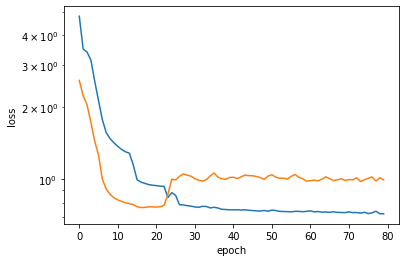

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale('log')

Text(0, 0.5, 'acc')

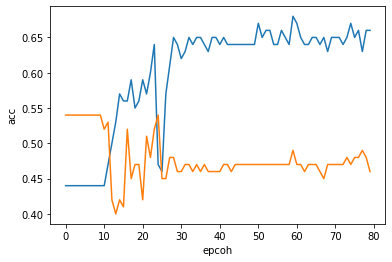

In [24]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.xlabel("epcoh")
plt.ylabel("acc")

The CNN can build in the same way by using different cirquits for the one qbit, two qbit and pooling cirquits.  
I wanted to try some of the proposed circuits from figure 2 and 3 from 2108.00661.  
For example I implement the Convolutional circuit 3 from Fig. 2 which consists of 2 Y rotations per qbit and two cnot gates between them
this leads less parameters.

In [25]:
# one parameter
def one_qubit_unitary(bit, symbol):
    return cirq.Circuit(cirq.Y(bit)**symbol)

# four parameters
def two_qubit_unitary(bits, symbols):
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0])
    circuit += one_qubit_unitary(bits[1], symbols[1])
    circuit += cirq.CNOT(bits[0],bits[1])
    circuit += one_qubit_unitary(bits[0], symbols[2])
    circuit += one_qubit_unitary(bits[1], symbols[3])
    circuit += cirq.CNOT(bits[1],bits[0])
    return circuit

# two parameters
def two_qubit_pool(in_qubit, out_qubit, symbols):
    pool_circuit = cirq.Circuit()
    pool_circuit.append((cirq.Y(in_qubit).controlled_by(out_qubit))**symbols[0])
    pool_circuit.append((cirq.Y(in_qubit).controlled_by(out_qubit, control_values=[0]))**symbols[1])
    return pool_circuit

The rest of the circuit and the model is the same as before.

In [26]:
def qcnn_layer(bits, symbols):
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit
  
    
def qpool_layer(in_bits, out_bits, symbols):
    circuit = cirq.Circuit()
    for source, sink in zip(in_bits, out_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit

In [34]:
model_circuit = cirq.Circuit()
symbols = sympy.symbols('qconv0:300')

qubits = cirq.GridQubit.rect(IMAGE_SIZE, IMAGE_SIZE)

total_qbits = IMAGE_SIZE*IMAGE_SIZE
num_active_qbits = IMAGE_SIZE*IMAGE_SIZE

layer = 0

while num_active_qbits > 1:
    model_circuit += qcnn_layer(qubits[total_qbits - num_active_qbits:], symbols[layer * 6:layer * 6 + 4])
    model_circuit += qpool_layer(qubits[total_qbits - num_active_qbits:num_active_qbits // 2 + total_qbits - num_active_qbits], 
                                 qubits[num_active_qbits // 2 + total_qbits - num_active_qbits:], symbols[layer * 6 + 4:(layer + 1) * 6])    
    print("Layer ",layer,":")
    print("Convolution qbits: ", len(qubits[total_qbits - num_active_qbits:]))
    print("in qbits: ", len(qubits[total_qbits - num_active_qbits:num_active_qbits // 2 + total_qbits - num_active_qbits]))
    print("out qbits: ", len(qubits[num_active_qbits // 2 + total_qbits - num_active_qbits:]))
    layer += 1
    num_active_qbits = len(qubits[num_active_qbits // 2 + total_qbits - num_active_qbits:])
    
    
readout_operators = cirq.Z(qubits[-1])
input_layer = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

quantum_model = tfq.layers.PQC(model_circuit,
                              readout_operators)(input_layer)


qcnn_model = tf.keras.Model(inputs=[input_layer], outputs=[quantum_model])

es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                   loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=[tf.keras.metrics.BinaryAccuracy()])


Layer  0 :
Convolution qbits:  16
in qbits:  8
out qbits:  8
Layer  1 :
Convolution qbits:  8
in qbits:  4
out qbits:  4
Layer  2 :
Convolution qbits:  4
in qbits:  2
out qbits:  2
Layer  3 :
Convolution qbits:  2
in qbits:  1
out qbits:  1


Now the model has way less parameters resulting in a lot faster training times

In [30]:
qcnn_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None,)]                 0         
                                                                 
 pqc_4 (PQC)                 (None, 1)                 24        
                                                                 
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = qcnn_model.fit(x=x_train_tfcirc,
                         y=y_train,
                         batch_size=16,
                         epochs=80,
                         validation_data=(x_test_tfcirc, y_test),
                         callbacks=[es])

Epoch 1/80
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
7/7 [==============================] - ETA: 0s - loss: 2.7352 - binary_accuracy: 0.4400WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe0fc94df80> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

In addition this second model seems to converge a lot faster

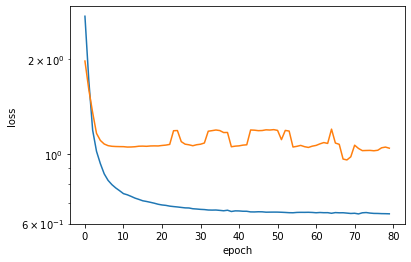

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale('log')

Text(0, 0.5, 'acc')

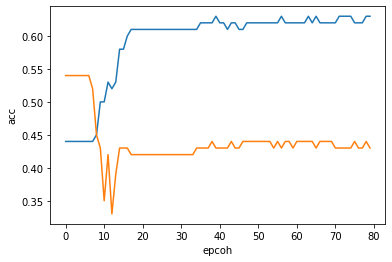

In [39]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.xlabel("epcoh")
plt.ylabel("acc")